# SLIC superpixels

Differentiable SLIC from Superpixel Sampling Networks from [Jampani et al](https://openaccess.thecvf.com/content_ECCV_2018/papers/Varun_Jampani_Superpixel_Sampling_Networks_ECCV_2018_paper.pdf). [Implemented](https://github.com/NVlabs/ssn_superpixels) with Caffe..

1. Compute initial superpixel center in regular grid cells $S^0_{m \times k} = I(F)$
2. For each iteration $t$ in $[1,...,v]$:
3. | Compute associations for each pixel $p$ and surrounding superpixel $i$: $Q^t_{pi}=e^{-||F_p - S_i^{t-1}||^2}$
4. | Compute new superpixel centers $S^t_i = \frac{1}{Z^t_i}\sum^n_{p=1}Q^t_{pi}F_p$, where $Z^t_i = \sum_p Q^t_{pi}$



### Issue: How to compute $S^0$?

After the first segmentation, how to define what is a regular distribution of centroids in a graph? How to do graph sampling?

## Implementations

In [2]:
import torch
import numpy as np 
import matplotlib.pyplot as plt

from skimage.data import coffee
from skimage.util import img_as_float

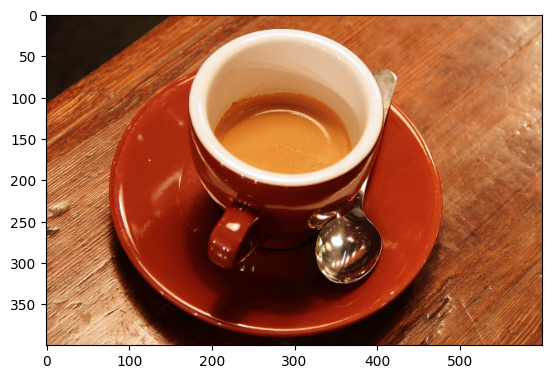

In [3]:
img = img_as_float(coffee())
plt.imshow(img)

### skimage implementation

Not differentiable because of hard pixel-superpixel associations!

In [4]:
from skimage.segmentation import slic, mark_boundaries

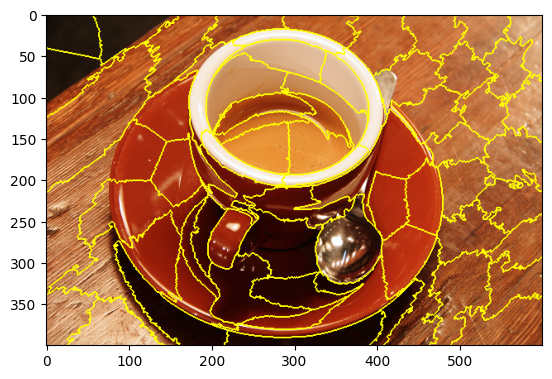

In [5]:
segments = slic(img)
plt.imshow(mark_boundaries(img, segments))

### Differentiable version with pytorch ....

#### Computing $S^0$ and $Q^0$

In [102]:
img_height, img_width, _ = img.shape

k = torch.tensor(100) # n_segments 

k_w = int(torch.floor(torch.sqrt(k*img_width/img_height)))
k_h = int(torch.floor(torch.sqrt(k*img_height/img_width)))

sp_w = img_width / (k_w*1.)
sp_h = img_height / (k_h*1.)

coord_w = torch.arange(sp_w/2, img_width  + 0.5, sp_w)/img_width
coord_h = torch.arange(sp_h/2, img_height + 0.5, sp_h)/img_height

coord_w, img_width



(tensor([0.0417, 0.1250, 0.2083, 0.2917, 0.3750, 0.4583, 0.5417, 0.6250, 0.7083,
         0.7917, 0.8750, 0.9583]),
 600)

In [25]:
from torch.nn.functional import interpolate

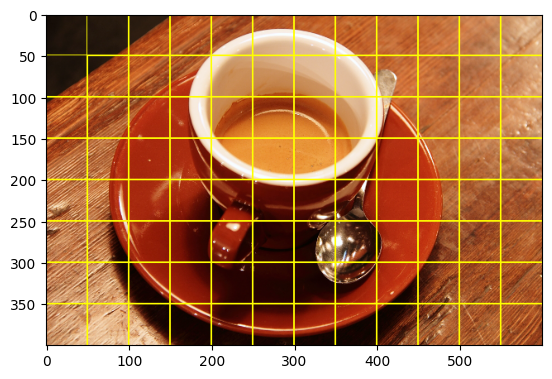

In [103]:
sp_mask = torch.arange(0, k_w * k_h, 1, dtype=torch.float).reshape((k_h, k_w))
sp_mask = interpolate(sp_mask.unsqueeze(0).unsqueeze(0), (img_height, img_width), mode='nearest').squeeze()
plt.imshow(mark_boundaries(img, sp_mask.to(torch.int32).numpy()))

In [63]:
img_t = torch.tensor(img.T)
img_t

tensor([[[0.0824, 0.0824, 0.0824,  ..., 0.7412, 0.8118, 0.7725],
         [0.0824, 0.0824, 0.0902,  ..., 0.8392, 0.7882, 0.7647],
         [0.0784, 0.0784, 0.0784,  ..., 0.7725, 0.7686, 0.7569],
         ...,
         [0.8941, 0.8941, 0.8941,  ..., 0.6471, 0.6039, 0.6196],
         [0.9059, 0.9059, 0.8941,  ..., 0.6314, 0.5765, 0.5647],
         [0.8941, 0.8980, 0.8980,  ..., 0.5608, 0.5686, 0.5608]],

        [[0.0510, 0.0510, 0.0549,  ..., 0.4863, 0.5804, 0.5529],
         [0.0510, 0.0510, 0.0510,  ..., 0.6078, 0.5569, 0.5373],
         [0.0431, 0.0549, 0.0549,  ..., 0.5529, 0.5490, 0.5412],
         ...,
         [0.7137, 0.7137, 0.7137,  ..., 0.3373, 0.2902, 0.2863],
         [0.7255, 0.7255, 0.7216,  ..., 0.3216, 0.2588, 0.2510],
         [0.7216, 0.7176, 0.7255,  ..., 0.2627, 0.2549, 0.2353]],

        [[0.0314, 0.0275, 0.0275,  ..., 0.3020, 0.4000, 0.3922],
         [0.0353, 0.0353, 0.0392,  ..., 0.4275, 0.3882, 0.3882],
         [0.0314, 0.0275, 0.0353,  ..., 0.3922, 0.3804, 0.

In [22]:
np.arange(-sp_w/2., img_width - 1 + sp_w, sp_w).shape

(14,)